## In this notebook, we create a simple month conditioned flood diffusion model

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

import rasterio
from rasterio.enums import Resampling
from natsort import natsorted
from tqdm import tqdm
import os
from pathlib import Path
import re
from datetime import datetime

def imshow_normalized(tensor_img, mean = (0.5, ), std = (0.5, )):
    """
    Function that displays a normalized tensor image using matplotlib.
    
    """
    assert tensor_img.dim() == 3, "Input tensor must be 3-dimensional (C, H, W)"
    img = tensor_img.clone().cpu().numpy()
    assert len(mean) == img.shape[0] and len(std) == img.shape[0], "Mean and std must match number of channels"
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]  # Unnormalize

    # Transpose to H, W, C
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')


In [ ]:
class FloodDataset(Dataset):
    def __init__(self, root_dir, target_size = (1024, 1024), transform = None):
        self.root_dir = Path(root_dir)
        self.target_size = target_size
        self.transform = transform

        image_paths = natsorted(list(self.root_dir.rglob('*.tif')))
        self.tile_to_int_map = self.tile_to_int(image_paths)
        
        if not image_paths:
            raise ValueError(f"No .tif files found in {root_dir}")
        
        self.path_month = []

        for p in image_paths:
            try:
                month = self._infer_month_from_path(p)
                self.path_month.append((p, month))
            except ValueError as e:
                print(f"Skipping {p.name}: {e}")

        # self.months = [self._infer_month_from_path(p) for p in self.image_paths]
        
    def __len__(self):
        return len(self.path_month)
    
    def __getitem__(self, idx):
        # Obtain image path and corresponding month
        img_path, month = self.path_month[idx]
        # month = int(self._infer_month_from_path(img_path))

        # Resample image to target size
        arr = self._resample(img_path)
      
        # Arr is currently uint8 values, 0, 1, 2
        mask = np.where(arr == 2, 1, 0).astype(np.uint8)
        # mask = mask[None, :, :]  # 1, H, W
        mask = torch.from_numpy(mask).to(torch.float32).unsqueeze(0)  # 1, H, W
        arr = None

        if self.transform:
            mask = self.transform(mask)

        meta = {
            "path": str(img_path),
            "month": month
        }

        return mask, int(month - 1), meta

    
    def _resample(self, p: Path) -> np.ndarray:
        """
        Use rasterio to resample the first band to target size.
        """
        with rasterio.open(p) as src:
            arr = src.read(
                1,
                out_shape = self.target_size,
                resampling = Resampling.nearest # Since these are binary flood maps
            )

        return arr.astype(np.uint8)
    
    @staticmethod
    def tile_to_int(image_paths):
        tile_list = []
        pattern = re.compile(r'([A-Z]\d+[A-Z]\d+)')
        for p in image_paths:
            match = pattern.search(p.stem)
            if match:
                tile_list.append(match.group(1))
            else:
                tile_list.append(None)

        # Get unique tiles and map to integers
        unique_tiles = natsorted(set(filter(None, tile_list)))

        tile_to_int_map = {tile: idx for idx, tile in enumerate(unique_tiles)}
        return tile_to_int_map

    @staticmethod
    def _infer_month_from_path(path):
        filename = path.stem

        match = re.match(r'^(\d{4}-\d{2})', filename)
        if match:
            year_month = match.group(1)
            year_month = datetime.strptime(year_month, "%Y-%m")
            return year_month.month
        else:
            raise ValueError(f"Filename {filename} does not match expected pattern 'YYYY-MM...'.")
            # print(f"Pattern not found in filename: {filename}. Defaulting to None.")
            # return None

In [ ]:
# Define data directory
data_dir = Path("flood_data/monthly_flood_maps")
BATCH_SIZE = 8 

# Define transforms
transform = v2.Compose([
    # Convert to float32 tensor: used if input is numpy array
    v2.ToImage(), # Convert to tensor, only needed if input is numpy array or PIL image 
    v2.ToDtype(torch.float32, scale = False),

    # Apply random horizontal flip
    v2.RandomHorizontalFlip(p = 0.5),
    # Apply normalization to center data around 0, this will scale values to [-1, 1]
    v2.Normalize(mean = [0.5], std = [0.5])
])

    
# Create dataset
flood_dataset = FloodDataset(data_dir, target_size = (1024, 1024), transform = transform)

# Define data loader
flood_dataloader = DataLoader(
    dataset = flood_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 4,
)

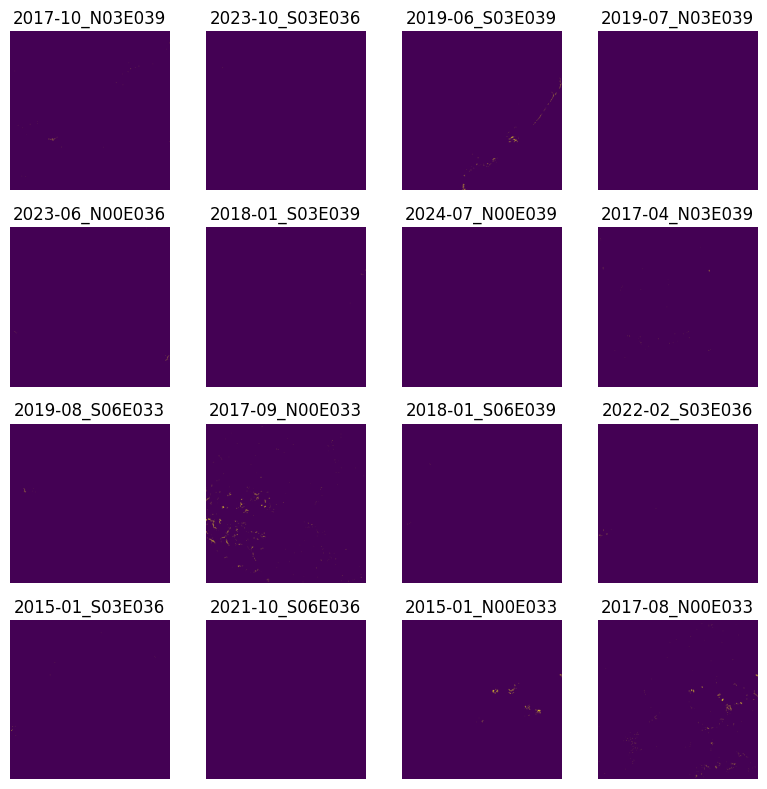

In [ ]:
plt.figure(figsize = (10, 10))
rows, cols = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randperm(len(flood_dataset))[0]
    # Get a sample
    sample = flood_dataset[sample_idx]
    img, label, meta = sample
    plt.subplot(rows, cols, i)
    imshow_normalized(img)
    plt.title(f"{Path(meta['path']).stem.split('_flood_map')[0]}")

plt.tight_layout()
plt.savefig("flood_samples.png", dpi = 1000)

## Conditional generative model for flood extents

In [ ]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.func import vmap, jacrev
from abc import ABC, abstractmethod

class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            num_samples (int): number of samples to draw
        Returns:
            samples (torch.Tensor): samples drawn from the distribution [batch_size, ...]
            labels (Optional[torch.Tensor]): optional labels associated with samples [batch_size, label_dim]
        """
        pass

# Define the abstract base class for sampling conditional probability paths
class ConditionalProbabilityPath(nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    p_0(.|z) = p_init
    p_1(.|z) = p_data 
    """
    def __init__(self, p_simple, p_data):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t):
        """
        Sample from the marginal distribution at time t: p_t(x) = \int p_t(x|z)p(z) dz
        z ~ p_data(z), x ~ p_t(x|z)

        Args:
            t: [B, 1, 1, 1]
        Returns:
            x: transition state samples [B, C, H, W]
        """
        num_samples = t.shape[0]

        # Sample conditioning variable z ~ p_data(z)
        z, _ = self.sample_conditioning_variable(num_samples) # [B, C, H, W]

        # Sample from the conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # [B, C, H, W]

        return x
    

    @abstractmethod
    def sample_conditioning_variable(self, num_samples):
        """
        Samples the conditioning variable z and guiding label y
        Args:
            num_samples (int): number of samples to draw
        Returns:
            -z [B, C, H, W]
            -y [B, label_dim]
        """
        pass

    @abstractmethod
    def sample_conditional_path(self, z, t):
        """
        Sample from the conditional distribution at time t: x ~ p_t(x|z)
        Args:
            z: conditioning variable [B, C, H, W]
            t: time [B, 1, 1, 1]
        Returns:
            x: transition state samples from p_t(.|z) [B, C, H, W]  
        """
        pass

    @abstractmethod
    def conditional_vector_field(self, x, z, t):
        """
        Compute the conditional vector field u_t(x|z) 
        Args:
            x: transition state [B, C, H, W]
            z: conditioning variable [B, C, H, W]
            t: time [B, 1, 1, 1]
        Returns:
            u: conditional vector field [B, C, H, W]
        """
        pass

    @abstractmethod
    def conditional_score(self, x, z, t):
        """
        Compute the conditional score \nabla_x log p_t(x|z)
        Args:
            x: transition state [B, C, H, W]
            z: conditioning variable [B, C, H, W]
            t: time [B, 1, 1, 1]
        Returns:
            s: conditional score [B, C, H, W]
        """
        pass

## Creating noise schedulers


class Alpha(ABC):
    """
    Base class for alhpa_t function that scale the data
    """
    def __init_(self):
        super().__init__()
        # Check alpha_t(0) == 0
        assert torch.allclose(
            self(torch.zeros(1, 1, 1, 1), torch.zeros(1, 1, 1, 1)),
        )
        # Check alpha_t(1) == 1
        assert torch.allclose(
            self(torch.ones(1, 1, 1, 1), torch.ones(1, 1, 1, 1)),
        )

    @abstractmethod
    def __call__(self, t):
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
         Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
         
        """
        pass

    def dt(self, t):
        """
        Evaluates d/dt alpha_t

        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """
        t = t.unsqueeze(1)
        # Jacobian wrt a single variable is derivative
        # Define derivative of self.__call__(t_i) for single input
        dt = jacrev(self)
        # Vectorize over batch dimension
        dt = vmap(dt)(t)
        return dt.view(-1, 1, 1, 1)
    

class Beta(ABC):
    """
    Base class for beta_t function that scale the noise
    """
    def __init__(self):
        super().__init__()
        # Check beta_t(0) == 1
        assert torch.allclose(
            self(torch.zeros(1, 1, 1, 1)),
            torch.ones(1, 1, 1, 1)
        )
        # Check beta_t(1) == 0
        assert torch.allclose(
            self(torch.ones(1, 1, 1, 1)),
            torch.zeros(1, 1, 1, 1)
        )

    @abstractmethod
    def __call__(self, t):
        """
        Evaluates beta_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
         Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - beta_t (num_samples, 1, 1, 1)
         
        """
        pass

    def dt(self, t):
        """
        Evaluates d/dt beta_t

        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt beta_t (num_samples, 1, 1, 1)
        """
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)
    



In [ ]:
# Implement linear alpha and beta functions
class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """
    def __call__(self, t):
        return t
    
    def dt(self, t):
        """"
        Evaluates d/dt alpha_t
        """
        return torch.ones_like(t)
    
class LinearBeta(Beta):
    """
    Implements beta_t = 1 - t
    """
    def __call__(self, t):
        return 1.0 - t
    
    def dt(self, t):
        """"
        Evaluates d/dt beta_t
        """
        return torch.ones_like(t) * -1.0

In [ ]:
## Update ODE, SDE and simulator classes
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt, t, **kwargs):
        """
        Computes the drift coefficient of the ODE ie vector field u_t(x|z)
        Args:
        xt: transition state at time t [B, C, H, W]
            t: time [B, 1, 1, 1]
        Returns:
            u_t(xt|z): drift coefficient [B, C, H, W]
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt, t, **kwargs):
        """
        Computes the drift coefficient of the SDE u_t(xt|z)
        vector field + score
        Args:
            xt: transition state at time t [B, C, H, W]
            t: time [B, 1, 1, 1]
        Returns:
            u_t(xt|z): drift coefficient [B, C, H, W]
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt, t):
        """
        Computes the diffusion coefficient of the SDE: sigma * dWT
        """
        pass


class Simulator(ABC):
    @abstractmethod
    def step(self, xt, t, dt, **kwargs):
        """
        Performs a single simulation step
        x_t+h = x_t + dt * u_t(x_t|z)
        Args:
            xt: transition state at time t [B, C, H, W]
            t: time [B, 1, 1, 1]
            dt: time step (scalar)
        Returns:
            x_t+h: transition state at time t+h [B, C, H, W]
        """
        pass

    @torch.no_grad()
    def simulate(self, x, ts, **kwargs):
        """"
        Simulates the ODE/SDE from time t=0 to t=1
        Args:
            x0: initial state [B, C, H, W]
            ts: all time steps [B, nts, 1, 1, 1]

        Returns:
            xts: Final transition state at t=1 [B, C, H, W]
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx] # [B, 1, 1, 1]
            h = ts[:, t_idx + 1] - t # [B, 1, 1, 1]
            x = self.step(x, t, h, **kwargs) # [B, C, H, W]
        return x
    
    @torch.no_grad()
    def simulate_with_trajectory(self, x, ts, **kwargs):
        """
        Simulates the ODE/SDE from time t=0 to t=1 and records the full trajectory
        Args:
            x0: initial state [B, C, H, W]
            ts: all time steps [B, nts, 1, 1, 1]
        Returns:
            xts: all transition states [B, nts, C, H, W]
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - t
            x = self.step(x, t, h, **kwargs) # [B, C, H, W]
            xs.append(x.clone())

        return torch.stack(xs, dim = 1) # [B, nts, C, H, W]

In [ ]:
# Implement Euler and Euler-Maruyama simulators
class EulerSimulator(Simulator):
    def __init__(self, ode):
        self.ode = ode

    def step(self, xt, t, h, **kwargs):
        """
        Performs a single simulation step
        x_t+h = x_t + h * u_t(x_t|z)
        """
        x_t_plus_h = xt + h * self.ode.drift_coefficient(xt, t, **kwargs)
        return x_t_plus_h
    
class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde):
        self.sde = sde

    def step(self, xt, t, h, **kwargs):
        """
        Performs a single simulation step
        x_t+h = x_t + h * u_t(x_t|z) + diffusion_coef * (sqrt(h) * eps, eps ~ N(0, I))
        """
        noise = torch.randn_like(xt) * torch.sqrt(h) # Noise with a variance of h
        x_t_plus_h = xt + h * self.sde.drift_coefficient(xt, t, **kwargs) + self.sde.diffusion_coefficient(xt, t, **kwargs) * noise
        return x_t_plus_h
    
def record_every(num_timesteps, record_every):
    """
    Returns a list of indices to record
    Args:
        num_timesteps: total number of timesteps
        record_every: record every n timesteps
    Returns:
        indices: list of indices to record
    
    """
    if record_every == 1:
        return torch.arange(0, num_timesteps)
    
    return torch.cat(
        [
            torch.arange(0, num_timesteps, record_every),
            torch.tensor([num_timesteps - 1])
        ]
    )

In [ ]:
## Instantiate Gaussian Conditional Probability Path
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    """
    Conditional probability path where p_t(.|z) = N(x; alpha_t * z, beta_t^2 * I)
    """
    def __init__(self, p_data, p_simple_shape, alpha, beta):
        p_simple = IsotropicGaussian(shape = p_simple_shape, std = 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples):
        """
        Samples the conditioning variable z and guiding label y
        Args:
            num_samples (int): number of samples to draw
        Returns:
            -z [B, C, H, W]
            -y [B, label_dim]
        """
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z, t):
        """
        Sample from the conditional probability path x ~p_t(.|z) = N(x; alpha_t * z, beta_t^2 I)

         x = alpha_t * z + beta_t * eps, eps ~ N(0, I)
        Args:
            z: conditioning variable [B, C, H, W]
            t: time [B, 1, 1, 1]
        Returns:
            x: transition state from p_t(.|z) [B, C, H, W]
        
        """
        noise = torch.randn_like(z)  # eps ~ N(0, I)
        return self.alpha(t) * z + self.beta(t) * noise
    

    def conditional_vector_field(self, x, z, t):
        """
        Computes the conditional vetcor field u_t(x|z) = [dt_alpha_t - dt_beta_t / beta_t * alpha_t]*z + dt_beta_t / beta_t * x
        Args:
            x: transition state [B, C, H, W]
            z: conditioning variable [B, C, H, W]
            t: time [B, 1, 1, 1]
        Returns:
            u_t(x|z): conditional vector field [B, C, H, W]
        """
        alpha_t = self.alpha(t) # [B, 1, 1, 1]
        beta_t = self.beta(t)   # [B, 1, 1, 1]
        dt_alpha_t = self.alpha.dt(t) # [B, 1, 1, 1]
        dt_beta_t = self.beta.dt(t)   # [B, 1, 1, 1]

        scale_z = (dt_alpha_t - (dt_beta_t / beta_t) * alpha_t) * z # [B, C, H, W]
        scale_x = (dt_beta_t / beta_t) * x                           # [B, C, H, W]
        return scale_z + scale_x # [B, C, H, W]
    

    def conditional_score(self, x, z, t):
        """
        Computes the conditional score \nabla_x log p_t(x|z) = (alpha_t * z - x) / beta_t^2
        The score points towards the direction of higher data likelihood
        """
        alpha_t = self.alpha(t) # [B, 1, 1, 1]
        beta_t = self.beta(t)   # [B, 1, 1, 1]
        return (z * alpha_t - x) / (beta_t ** 2) # [B, C, H, W]




In [ ]:
# 1MB = 1024 ** 2 bytes 
MiB = 1024 ** 2

def model_size_b(model):
    """
    Returns model size in bytes. Based on https://discuss.pytorch.org/t/finding-model-size/130275/2
    """
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.losses = []

    @abstractmethod
    def get_train_loss(self, **kwargs):
        pass

    def get_optimizer(self, lr):
        return torch.optim.Adam(self.model.parameters(), lr = lr)
    
    def train(self, num_epochs, device, lr = 1e-3, **kwargs):
        # Report model size
        size_b = model_size_b(self.model)
        print(f"Model size: {size_b / MiB:.3f} MiB")

        # Move model to device and set to train mode
        self.model.to(device)
        self.model.train()
        optimizer = self.get_optimizer(lr)

        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:

            # Zero out previous accumulated gradients
            optimizer.zero_grad()

            # Forward pass and compute loss
            loss = self.get_train_loss(**kwargs)
            self.losses.append(loss.item())

            # Gradient of loss wrt model parameters
            loss.backward()

            # Update model parameters
            optimizer.step()

            pbar.set_description(f"Epoch {idx}, loss: {loss.item():.3f}")

        # Final mode to eval
        self.model.eval()
        return self.losses



In [ ]:
## Create sampleable wrapper for flood map dataset
class flood_map_sampler(nn.Module, Sampleable):
    """
    Sampleable wrapper for flood map dataset
    """
    def __init__(self):
        super().__init__()
        self.dataset = flood_dataset
        self.register_buffer("dummy", torch.zeros(1))

    def sample(self, num_samples):
        if num_samples > len(self.dataset):
            raise ValueError(f"Requested {num_samples} samples, but dataset only has {len(self.dataset)} samples.")
        
        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples = [self.dataset[i][0] for i in indices]
        
        month_labels = [self.dataset[i][1] for i in indices]
        location_labels = [re.search(r'([A-Z]\d+[A-Z]\d+)', self.dataset[i][2]["path"]).group(1) for i in indices]
        location_labels = [self.dataset.tile_to_int_map[loc] for loc in location_labels]


        samples = torch.stack(samples, dim = 0).to(self.dummy)  # B, C, H, W
        month_labels = torch.tensor(month_labels, device = self.dummy.device) # B
        location_labels = torch.tensor(location_labels, device = self.dummy.device) # B
        return samples, month_labels, location_labels

# create a sampleable dataset for Gaussian
class IsotropicGaussian(nn.Module, Sampleable):
    """
    Sampleable wrapper around torch.randn
    """
    def __init__(self, shape: List[int], std: float = 1.0):
        super().__init__()
        self.shape = shape
        self.std = std
        self.register_buffer("dummy", torch.zeros(1))

    def sample(self, num_samples):
        # Sample from standard normal and scale by std
        samples = torch.randn((num_samples, *self.shape)) * self.std
        return samples.to(self.dummy.device), None # [B, C, H, W], None

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

num_rows = 1
num_cols = 1
num_timesteps = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize data sampler
p_data = flood_map_sampler().to(device)

# Initialize Gaussian conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = p_data,
    p_simple_shape = (1, 1024, 1024),
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Draw sampled from p_data
num_samples = num_rows * num_cols
sampled_data, month_labels, location_labels = path.p_data.sample(num_samples)
z = sampled_data.view(-1, 1, 1024, 1024)  # B, C, H, W
z.min(), z.max()


# Define time steps
ts = torch.linspace(0, 1, num_timesteps).to(device)

# Setup plots
fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))


for tidx, t in enumerate(ts):
    tt = t.view(1, 1, 1, 1).expand(num_samples, 1, 1, 1)  # B, 1, 1, 1

    # Sample from conditional probability path p_t(.|z)
    # x_t = alpha_t * z + beta_t * noise
    xt = path.sample_conditional_path(z, tt)  # B, C, H, W
    grid = make_grid(xt, nrow = num_rows, normalize = True, value_range = (-1, 1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap = 'viridis')
    axes[tidx].set_title(f"t={t.item():.2f}")
    axes[tidx].axis('off')

plt.tight_layout()
plt.savefig("flood_simulation1.png", dpi = 500)
plt.show()


In [ ]:
## Define conditional vector field as a CNN for now
class ConditionalVectorFieldCNN(nn.Module, ABC):
    """
    CNN parameterization of the learned marginal vector field u_t^theta(x|z)
    """
    @abstractmethod
    def forward(self, x, t, y):
        """
        Args:
            x: transition state [B, C, H, W]
            t: time [B, 1, 1, 1]
            y: guiding label [B, label_dim]
        Returns:
            u_t^theta(x|z): conditional vector field [B, C, H, W]
        """
        pass

class CFGVectorFieldODE(ODE):
    def __init__(self, net: ConditionalVectorFieldCNN, guidance_scale = 1.0):
        self.net = net
        self.guidance_scale = guidance_scale

    def drift_coefficient(self, x, t, y):
        """
        Predicts the vector field
        x: transition state [B, C, H, W]
        t: time [B, 1, 1, 1]
        y: guiding label [B, label_dim]
        Returns:
            u_t^theta(x|y) = wu_t^theta(x|y) + (1-w)u_t^theta(x|0)
        """
        # Guided model prediction
        guided_vector_field = self.net(x, t, y)  # [B, C, H, W]

        # Unguided model prediction
        unguided_y_month = torch.ones_like(y[0]) * 12 # Month label 12 for unguided
        unguided_y_location = torch.ones_like(y[1]) * len(p_data.dataset.tile_to_int_map)  # Max location label for unguided
        
        unguided_y = torch.stack([unguided_y_month, unguided_y_location], dim = 0) # [2, B]
        unguided_vector_field = self.net(x, t, unguided_y)  # [B, C, H, W]

        # Combine guided and unguided predictions
        combined_vector_field = (self.guidance_scale * guided_vector_field) + ((1 - self.guidance_scale) * unguided_vector_field)
        
        return combined_vector_field

In [ ]:
## Create CFG trainer
## Labels ae dropped with prop n

class CFGTrainer(Trainer):
    def __init__(self, path, model, eta, device, **kwargs):
        assert eta > 0 and eta <1
        super().__init__(model, **kwargs)
        self.eta = eta
        self.path = path
        self.device = device

    def get_train_loss(self, batch_size):
        # Sample time from a uniform distribution
        # t ~ uniform(0, 1)
        t = torch.rand(batch_size, 1, 1, 1, device = self.device)  # [B, 1, 1, 1]

        # Sample data point z and labels y from p_data 
        # z, y ~ p_data
        z, month_labels, location_labels = self.path.sample_conditioningvariable(batch_size) # z: [B, C, H, W], month_labels: [B], location_labels: [B]

        # Randomly drop labels with probability eta
        drop_mask = torch.rand(batch_size, device = month_labels.device) < self.eta  # [B]
        month_labels = month_labels.masked_fill(drop_mask, 12) # Where month label 12 indicates no guidance
        location_labels = location_labels.masked_fill(drop_mask, len(self.path.p_data.dataset.tile_to_int_map)) # Where location label len(...) indicates no guidance           
        y = torch.stack([month_labels, location_labels], dim = 0)  # [2, B]

        # Sample from the conditional probability path
        # x_t ~ p_t(.|z) x = alpha_t * z + beta_t * noise
        x_t = self.path.sample_conditional_path(z, t)  # [B, C, H, W]

        # Compute the conditional vector field
        # u_t(x|z) = [dt_alpha_t - dt_beta_t / beta_t * alpha_t]*z + dt_beta_t  beta_t * x
        ut_ref = self.path.conditional_vector_field(x_t, z, t)  # [B, C, H, W]

        # Compute the model predicted vector field u_t^theta(x, y)
        ut_theta = self.model(x_t, t, y) # [B, C, H, W]

        # Compute MSE loss between reference and model predicted vector fields
        # error = torch.einsum('bchw -> b', torch.square(ut_theta - ut_ref)) # (bs,)
        error = torch.square(ut_theta - ut_ref)  # [B, C, H, W]
        error = torch.sum(error, dim = (1, 2, 3))  # [B]
        loss = torch.mean(error)  # scalar
        return loss
        


## Unet vector field model
Next we create a Unet model to be used as the vector field model for flow matching. The Unet will take in both the noisy flood data and the month label & location as input and output the vector field needed for flow matching.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ResidualLayer(nn.Module):
    def __init__(self, channels, time_embed_dim, y_embed_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(num_features = channels),
            nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
        )
        self.block2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(num_features = channels),
            nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
        )

        # Convert time embedding to a shape that can be added to feature map
        # [B, time_embed_dim] -> [N, channels]
        self.time_adapter = nn.Sequential(
            nn.Linear(in_features = time_embed_dim, out_features = time_embed_dim),
            nn.SiLU(),
            nn.Linear(in_features = time_embed_dim, out_features = channels)
        )

        # Convert y embedding to a shape that can be added to feature map
        # [B, y_embed_dim] -> [B, channels]
        self.y_adapter = nn.Sequential(
            nn.Linear(in_features = y_embed_dim, out_features = y_embed_dim),
            nn.SiLU(),
            nn.Linear(in_features = y_embed_dim, out_features = channels)
        )

    def forward(self, x, t_embed, y_embed):
        """
        Args:
            x: feature map [B, C, H, W]
            t_embed: time embedding [B, time_embed_dim]
            y_embed: y embedding [B, y_embed_dim]
            
        """
        
        # Create residual
        res = x.clone() # [B, C, H, W]

        # Transform time embedding to match feature map shape
        t_embed = self.time_adapter(t_embed) # [B, time_embed_dim] -> [B, channels]
        t_embed = t_embed[:, :, None, None] # [B, C] -> [B, C, 1, 1]

        # Transform y embedding to match feature map shape
        y_embed = self.y_adapter(y_embed) # [B, y_embed_dim] -> [B, channels]
        y_embed = y_embed[:, :, None, None] # [B, C] -> [B, C, 1, 1]

        # Initial Conv + BN + SiLU
        x = self.block1(x)  # [B, C, H, W] -> [B, C, H, W]

        # Add time and y embeddings
        x = x + t_embed + y_embed  # [B, C, H, W] + [B, C, 1, 1] + [B, C, 1, 1] -> [B, C, H, W]

        # Second Conv + BN + SiLU
        x = self.block2(x)  # [B, C, H, W] -> [B, C, H, W]

        # Add residual
        x = x + res  # [B, C, H, W] + [B, C, H, W] -> [B, C, H, W]

        return x
    

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_layers, t_embed_dim, y_embed_dim):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels = in_channels, time_embed_dim = t_embed_dim, y_embed_dim = y_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, stride = 2, padding = 1)

    def forward(self, x, t_embed, y_embed):
        """
        Args: 
            x: feature map [B, C, H, W]
            t_embed: time embedding [B, t_embed_dim]
            y_embed: y embedding [B, y_embed_dim]
        """
        # Pass through residual blocks
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)  # [B, C_in, H, W] -> [B, C_in, H, W]

        # Downsample: [B, C_in, H, W] -> [B, C_out, H/2, W/2]
        x = self.downsample(x)  # [B, C_out, H/2, W/2]

        return x

class Midcoder(nn.Module):
    def __init__(self, channels, num_residual_layers, t_embed_dim, y_embed_dim):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels = channels, time_embed_dim = t_embed_dim, y_embed_dim = y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x, t_embed, y_embed):
        """
        Args: 
            x: feature map [B, C, H, W]
            t_embed: time embedding [B, t_embed_dim]
            y_embed: y embedding [B, y_embed_dim]
        """
        # Pass through residual blocks: [B, C, H, W] -> [B, C, H, W]
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x
    
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_layers, t_embed_dim, y_embed_dim):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode = "nearest"), ## Should this be nearest?
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        )
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels = out_channels, time_embed_dim = t_embed_dim, y_embed_dim = y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x, t_embed, y_embed):
        ## Upsample [B, C_in, H, W] -> [B, C_out, H*2, W*2]
        x = self.upsample(x)

        # Pass through residual blocks
        for block in self.res_blocks: # [B, C_out, H*2, W*2] -> [B, C_out, H*2, W*2]
            x = block(x, t_embed, y_embed)

        return x
    
class FourierEncoder(nn.Module):
    """
    Used to encode the time step t into a higher dimensional space using Fourier features.
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim):
        super().__init__()
        assert dim % 2 == 0, "Fourier feature dimension must be even"
        self.half_dim = dim // 2 # Half dimension for sin and cos
        self.weights = nn.Parameter(torch.randn(1, self.half_dim)) # [1, half_dim] random initialized weights for frequency scaling

    def forward(self, t):
        """
        Args:
            t: [B] time step tensor
        Returns:
            t_embed: [B, t_embed_dim] Learned Fourier encoded time embedding

        """
        t = t.view(-1, 1) # [B, ...] -> [B, 1]
        # w = 2pi*f
        freqs = t * self.weights * 2 * math.pi # [B, 1] * [1, half_dim] -> [B, half_dim]
        sin_embed = torch.sin(freqs) # [B, half_dim]
        cos_embed = torch.cos(freqs) # [B, half_dim]
        t_embed = torch.cat([sin_embed, cos_embed], dim = -1) # [B, half_dim], [B, half_dim] -> [B, t_embed_dim]

        return t_embed * math.sqrt(2) # SO that the variance of each time embedding is 1. since var of sin and cos is 0.5 each


# # Simulate
# dim = 128
# half_dim = dim // 2
# weights = torch.randn(1, half_dim)
# t = torch.rand(10000, 1)  # Many random t for stats

# freqs = t * weights * 2 * math.pi
# sin_embed = torch.sin(freqs)
# cos_embed = torch.cos(freqs)
# embed = torch.cat([sin_embed, cos_embed], dim=-1)

# print("Variance without sqrt(2):", embed.var(dim=1).mean())  # ~0.5
# print("Variance with sqrt(2):", (embed * math.sqrt(2)).var(dim=1).mean())  # ~1.0


class ConditionEmbedding(nn.Module):
    """
    Embeds the guiding labels y ie for moth and location into a higher dimensional space
    """
    def __init__(self, num_month_embeddings, num_location_embeddings, y_embed_dim):
        super().__init__()
        self.month_embedding = nn.Embedding(num_embeddings = num_month_embeddings, embedding_dim = y_embed_dim)
        self.location_embedding = nn.Embedding(num_embeddings = num_location_embeddings, embedding_dim = y_embed_dim)
        self.proj = nn.Sequential(
            nn.Linear(in_features = 2 * y_embed_dim, out_features = y_embed_dim),
            nn.SiLU(),
            nn.Linear(in_features = y_embed_dim, out_features = y_embed_dim)
        )
    def forward(self, y):
        """
        Args:
            y: guiding labels [2, B] where y[0] is month labels and y[1] is location labels
        Returns:
            y_embed: embedded guiding labels [B, y_embed_dim]
        """
        month_labels = y[0].long()  # [B]
        location_labels = y[1].long()  # [B]

        month_embed = self.month_embedding(month_labels)  # [B, y_embed_dim]
        location_embed = self.location_embedding(location_labels)  # [B, y_embed_dim]

        # Concatenate month and location embeddings
        y_embed = torch.cat([month_embed, location_embed], dim = -1)  # [B, 2 * y_embed_dim]

        # Project to final y embedding
        y_embed = self.proj(y_embed)  # [B, y_embed_dim]

        return y_embed



In [ ]:
from typing import Optional, List, Type, Tuple, Dict
## Create Unet
class FloodUNet(ConditionalVectorFieldCNN):
    def __init__(
            self,
            channels: List[int],
            num_residual_layers: int,
            t_embed_dim: int,
            y_embed_dim: int
    ):
        super().__init__()

        # Initial convolution: [B, 1, H, W] -> [B, channels[0], H, W]
        self.initial_conv = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels= channels[0], kernel_size = 4, stride = 4, padding = 0), # Downsample by 4
            # nn.Conv2d(in_channels = 1, out_channels = channels[0], kernel_size = 3, padding = 1),
            nn.BatchNorm2d(num_features = channels[0]),
            nn.SiLU()
        )
        
        # Initialize time embedder
        self.time_embedder = FourierEncoder(dim = t_embed_dim) # [B, 1, 1, 1] -> [B, t_embed_dim]

        # Initialize condition embedder
        self.y_embedder = ConditionEmbedding(
            num_month_embeddings = 13,  # 12 months + 1 for no guidance
            num_location_embeddings = len(p_data.dataset.tile_to_int_map) + 1,  # num locations + 1 for no guidance
            y_embed_dim = y_embed_dim
        )

        # Encoders, Midcoder, Decoders
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()

        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            self.encoders.append(
                Encoder(
                    in_channels = curr_c,
                    out_channels = next_c,
                    num_residual_layers = num_residual_layers,
                    t_embed_dim = t_embed_dim,
                    y_embed_dim = y_embed_dim
                )
            )

            self.decoders.append(
                Decoder(
                    in_channels = next_c,
                    out_channels = curr_c,
                    num_residual_layers = num_residual_layers,
                    t_embed_dim = t_embed_dim,
                    y_embed_dim = y_embed_dim
                )
            )

        self.decoders = self.decoders[::-1]  # Reverse the order of decoders

        self.midcoder = Midcoder(
            channels = channels[-1],
            num_residual_layers = num_residual_layers,
            t_embed_dim = t_embed_dim,
            y_embed_dim = y_embed_dim
        )
        
        # Final convolution: [B, channels[0], H, W] -> [B, 1, H, W]
        self.final_conv = nn.Conv2d(in_channels = channels[0], out_channels = 1, kernel_size = 3, padding = 1)


    def forward(self, x, t, y):
        """
        Args:
            x: transition state [B, 1, H, W]
            t: time [B, 1, 1, 1] between 0 and 1
            y: guiding labels [2, B]
        Returns:
            u_t^theta(x|y): conditional vector field [B, 1, H, W]
        """
        
        # Create time and guiding label embeddings
        t_embed = self.time_embedder(t) # [B, t_embed_dim]
        y_embed = self.y_embedder(y)    # [B, y_embed_dim]

        # Initial conv
        x = self.initial_conv(x) # [B, 1, H, W] -> [B, channels[0], H, W]

        # Create empty list to store residuals for skip connections
        residuals = []

        # Pass through encoders
        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed)
            residuals.append(x.clone()) # Store residual for skip connection



        # Pass through midcoder
        x = self.midcoder(x, t_embed, y_embed)

        # Pass through decoders
        for decoder in self.decoders:
            res = residuals.pop()
            x = x + res # Add skip connection [B, C, H, W] + [B, C, H, W] -> [B, C, H, W]
            x = decoder(x, t_embed, y_embed)

        # Final conv
        x = self.final_conv(x) # [B, channles[0], H, W] -> [B, 1, H, W]

        return x
        

In [ ]:
## Train unet 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize probabilistic path
p_data = flood_map_sampler()
path = GaussianConditionalProbabilityPath(
    p_data = p_data,
    p_simple_shape = [1, 1024, 1024],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
floodnet = FloodUNet(
    channels = [32, 64, 128, 512],
    num_residual_layers = 2,
    t_embed_dim = 64,
    y_embed_dim = 64
).to(device)

# Initialize trainer
trainer = CFGTrainer(
    path = path,
    model = floodnet,
    eta = 0.1,
    device = device
)

# Train model
trainer.train(num_epochs = 5000, device = device, lr = 1e-3, batch_size = 8)